In [2]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [3]:
%cd D:/archive/food-101

D:\archive\food-101


## Load the data & preprocessing

In [5]:
import pandas as pd
train_df = pd.read_csv('food-101/meta/train.txt', header = None, names=['path'])
test_df = pd.read_csv('food-101/meta/test.txt', header = None, names=['path'])

In [58]:
train_df.describe()

,path,label,idx
count,60600,60600,60600
unique,60600,21,60600
top,food-101/images/beet_salad/3685.jpg,Others,3685
freq,1,48592,1


In [6]:
def spliter(data, class_or_id='id'):
    if class_or_id.upper() == 'CLASS':
        output = data.split('/')[0]
        
    else:
        output = data.split('/')[-1]
    return output

In [9]:
train_df['label'] = train_df['path'].map(lambda x: spliter(data = x, class_or_id = 'Class')) 
train_df.head()

,path,label
0,apple_pie/1005649,apple_pie
1,apple_pie/1014775,apple_pie
2,apple_pie/1026328,apple_pie
3,apple_pie/1028787,apple_pie
4,apple_pie/1043283,apple_pie


In [10]:
train_df['idx'] = train_df['path'].map(lambda x: spliter(x)) 
train_df.head()

,path,label,idx
0,apple_pie/1005649,apple_pie,1005649
1,apple_pie/1014775,apple_pie,1014775
2,apple_pie/1026328,apple_pie,1026328
3,apple_pie/1028787,apple_pie,1028787
4,apple_pie/1043283,apple_pie,1043283


In [11]:
test_df['label'] = test_df['path'].map(lambda x: spliter(x, 'class')) 
test_df['idx'] = test_df['path'].map(lambda x: spliter(x)) 
test_df.head()

,path,label,idx
0,apple_pie/1011328,apple_pie,1011328
1,apple_pie/101251,apple_pie,101251
2,apple_pie/1034399,apple_pie,1034399
3,apple_pie/103801,apple_pie,103801
4,apple_pie/1038694,apple_pie,1038694


In [12]:
#20개만 갖고 할게요
mini_20 = train_df['label'].unique()[:20]
mini_20 = [f.upper() for f in mini_20]
mini_20

['APPLE_PIE',
 'BABY_BACK_RIBS',
 'BAKLAVA',
 'BEEF_CARPACCIO',
 'BEEF_TARTARE',
 'BEET_SALAD',
 'BEIGNETS',
 'BIBIMBAP',
 'BREAD_PUDDING',
 'BREAKFAST_BURRITO',
 'BRUSCHETTA',
 'CAESAR_SALAD',
 'CANNOLI',
 'CAPRESE_SALAD',
 'CARROT_CAKE',
 'CEVICHE',
 'CHEESECAKE',
 'CHEESE_PLATE',
 'CHICKEN_CURRY',
 'CHICKEN_QUESADILLA']

In [13]:
def prepare_data(label):
    if label.upper() in mini_20:
        return label
    else:
        return 'Others'

In [14]:
train_df['label'] = train_df['label'].map(lambda x: prepare_data(x))
test_df['label'] = test_df['label'].map(lambda x: prepare_data(x))

In [15]:
train_df['label'].unique()

array(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio',
       'beef_tartare', 'beet_salad', 'beignets', 'bibimbap',
       'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad',
       'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake',
       'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'Others'],
      dtype=object)

In [16]:
def add_exact_path(path):
    return 'food-101/images/'+path+'.jpg'

In [17]:
train_df['path'] = train_df[['path']].apply(add_exact_path, axis=1)
test_df['path'] = test_df[['path']].apply(add_exact_path, axis=1)
train_df.head()

,path,label,idx
0,food-101/images/apple_pie/1005649.jpg,apple_pie,1005649
1,food-101/images/apple_pie/1014775.jpg,apple_pie,1014775
2,food-101/images/apple_pie/1026328.jpg,apple_pie,1026328
3,food-101/images/apple_pie/1028787.jpg,apple_pie,1028787
4,food-101/images/apple_pie/1043283.jpg,apple_pie,1043283


(512, 308, 3)

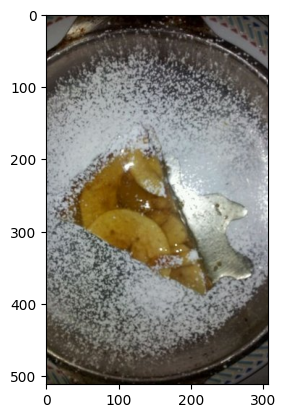

In [18]:
from matplotlib import pyplot as plt
img = plt.imread(train_df['path'].iloc[0])
plt.imshow(img)
img.shape

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True # 이미지의 절반을 무작위로 수평으로 뒤집습니다.
    )
test_gen = ImageDataGenerator(rescale=1./255)

## Split the train_data into training and validation

In [42]:
from sklearn.model_selection import train_test_split

# Split the original training data into training and validation
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [43]:
train_gen = datagen.flow_from_dataframe(dataframe=train_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb',
    classes=None, class_mode='categorical', batch_size=32, shuffle=True)

Found 60600 validated image filenames belonging to 21 classes.


In [44]:
# Create a new generator for validation data
valid_gen = datagen.flow_from_dataframe(dataframe=valid_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb',
    classes=None, class_mode='categorical', batch_size=32, shuffle=True)

Found 15150 validated image filenames belonging to 21 classes.


In [21]:
test_gen = test_gen.flow_from_dataframe(dataframe = test_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb',
    classes=None, class_mode='categorical', batch_size=32, shuffle=True)

Found 25250 validated image filenames belonging to 21 classes.


In [22]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.xception import Xception

In [45]:
from keras.applications.xception import Xception
from keras.models import Model

base_model = Xception(weights='imagenet', include_top=False)
x = base_model.get_layer('block1_conv2_act').output  # 이 레이어 이후의 레이어들을 제외합니다.

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(21, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [46]:
base_model = Xception(weights='imagenet', include_top=False)

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_5
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_16
13 block2_pool
14 batch_normalization_16
15 add_48
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_17
23 block3_pool
24 batch_normalization_17
25 add_49
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_18
33 block4_pool
34 batch_normalization_18
35 add_50
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_51
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [ ]:
# Xception = Xception(weights='imagenet', include_top=False)
# x = Xception.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256,activation='relu')(x)
# # x = Dropout(0.4)(x)
# x = Dense(128,activation='relu')(x)
# x = Dropout(0.2)(x)

# predictions = Dense(21, activation='softmax')(x)

In [48]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
history = model.fit(train_gen,
                    steps_per_epoch = len(train_gen) // 32,
                    validation_data = valid_gen,     # Add this line
                    validation_steps = len(valid_gen) // 32, # And this line
                    epochs=30,
                    workers=1,
                    verbose=1)

Epoch 1/30
59/59 [==============================] - 38s 637ms/step - loss: 1.8424 - accuracy: 0.6022 - val_loss: 1.1780 - val_accuracy: 0.7924
Epoch 2/30
59/59 [==============================] - 36s 614ms/step - loss: 1.1061 - accuracy: 0.8099 - val_loss: 1.2374 - val_accuracy: 0.7790
Epoch 3/30
59/59 [==============================] - 37s 623ms/step - loss: 1.1717 - accuracy: 0.7966 - val_loss: 1.2317 - val_accuracy: 0.7746
Epoch 4/30
59/59 [==============================] - 35s 599ms/step - loss: 1.0808 - accuracy: 0.8141 - val_loss: 1.2305 - val_accuracy: 0.7746
Epoch 5/30
59/59 [==============================] - 35s 593ms/step - loss: 1.1274 - accuracy: 0.8040 - val_loss: 1.0067 - val_accuracy: 0.8237
Epoch 6/30
59/59 [==============================] - 36s 602ms/step - loss: 1.1846 - accuracy: 0.7871 - val_loss: 1.2744 - val_accuracy: 0.7634
Epoch 7/30
59/59 [==============================] - 36s 619ms/step - loss: 1.1177 - accuracy: 0.8030 - val_loss: 1.0016 - val_accuracy: 0.8237

In [50]:
result = model.evaluate(test_gen, batch_size=32)
print(result)

790/790 [==============================] - 310s 392ms/step - loss: 1.0746 - accuracy: 0.8020
[1.0746150016784668, 0.801980197429657]


Text(0.5, 1.0, 'Training and Validation Accuracy')

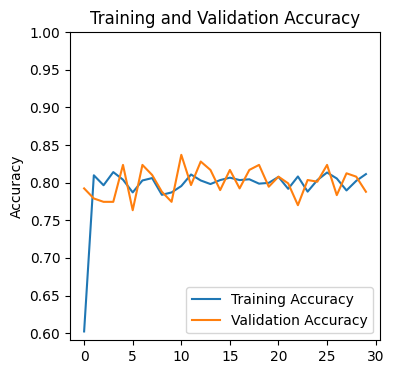

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(4, 4))
# plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

## Save the model

In [53]:
model.save('D:/archive/model/first.hdf5')

In [40]:
# Load the model
model = load_model('D:/archive/model/first.hdf5')